# Задача классификации на Kaggle с помощью логистической регрессии. Определение типа месторождения нефти и газа

### Цель проекта

Необходимо реализовать решение задачи классификации нефтегазовых месторождений: определить, относится ли месторождение к типу **onshore** (на суше) или **offshore** (на море) по совокупности географических, геологических и технологических параметров

Этапы работы:

* Провести исследование и первичный анализ данных (EDA)
* Выполнить предобработку данных (обработка пропусков, аномалий, кодирование категориальных признаков)
* При необходимости реализовать feature engineering
* Подобрать и проанализировать значимые признаки
* Обучить несколько моделей классификации и сравнить их качество
* Выполнить подбор гиперпараметров для ключевых моделей
* Выбрать лучшую модель и обосновать выбор
* Построить предсказания для тестового набора данных

Качество решения оценивается по метрике **F1-score**
Финальный ответ оформляется в виде файла `submission.csv` с двумя колонками:

* `index` — индекс строки тестового набора
* `Onshore/Offshore` — предсказанный класс (0 — OFFSHORE, 1 — ONSHORE, 2 — ONSHORE-OFFSHORE)

### Описание данных
* `train.csv` — тренировочный набор данных c целевой переменной (309 строк). [Скачать датасет](https://disk.yandex.ru/d/-drOTkpk1phipg)

* `test.csv` — тестовый набор данных без целевой переменной (133 строки). [Скачать датасет](https://disk.yandex.ru/d/izxHxDF5D17FYg)

Каждое месторождение описывается **19 признаками**:

* `Field name` — название месторождения;
* `Reservoir unit` — юнит (подразделение) месторождения;
* `Country` — страна расположения месторождения;
* `Region` — регион расположения;
* `Basin name` — название осадочного бассейна;
* `Tectonic regime` — тектонический режим;
* `Latitude` — широта месторождения;
* `Longitude` — долгота месторождения;
* `Operator company` — оператор / компания-разработчик;
* **`Onshore or offshore` — целевая переменная** (0 — OFFSHORE, 1 — ONSHORE, 2 — ONSHORE-OFFSHORE);
* `Hydrocarbon type (main)` — основной тип углеводорода (нефть, газ, конденсат и т.п.);
* `Reservoir status (current)` — текущий статус месторождения (в разработке, законсервировано и т.д.);
* `Structural setting` — структурные особенности месторождения;
* `Depth (top reservoir ft TVD)` — глубина залегания верхней границы коллектора (футы, TVD);
* `Reservoir period` — геологический/литологический период формирования коллектора;
* `Lithology (main)` — основная литология (тип породы);
* `Thickness (gross average ft)` — средняя общая мощность (толщина) пласта, ft;
* `Thickness (net pay average ft)` — средняя эффективная мощность пласта, ft;
* `Porosity (matrix average)` — средняя пористость коллектора;
* `Permeability (air average mD)` — средняя проницаемость (в миллидарси, mD).

На основе этих признаков необходимо построить модель, способную максимально точно классифицировать тип месторождения по признаку **Onshore/Offshore**.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.model_selection import GridSearchCV

import requests
import warnings
warnings.filterwarnings("ignore")
np.random.seed(42)

## 1. Загрузка датасетов по API с Яндекс.Диска.

In [4]:
def load_dataset_from_yadisk(public_key: str) -> pd.DataFrame:
    base_url = "https://cloud-api.yandex.net/v1/disk/public/resources/download"
    resp = requests.get(base_url, params={"public_key": public_key})
    resp.raise_for_status()
    download_url = resp.json()["href"]
    df = pd.read_csv(download_url)
    return df

# Заранее разбиваем их на обучающую и тестовую выборки
train_url = "https://disk.yandex.ru/d/izxHxDF5D17FYg"   
test_url  = "https://disk.yandex.ru/d/-drOTkpk1phipg"   

train = load_dataset_from_yadisk(train_url)
test  = load_dataset_from_yadisk(test_url)
train.shape, test.shape

((309, 20), (133, 19))

## 2. Первичный EDA
Смотрим структуру данных, типы, описательную статистику и пропуски.

In [6]:
display(train.head())
print(train.info())
print("\nЧисловые признаки (описательная статистика):")
display(train.describe())
print("\nПропуски в train:")
print(train.isna().sum())
print("\nПропуски в test:")
print(test.isna().sum())

,Field name,Reservoir unit,Country,Region,Basin name,Tectonic regime,Latitude,Longitude,Operator company,Onshore/Offshore,Hydrocarbon type,Reservoir status,Structural setting,Depth,Reservoir period,Lithology,Thickness (gross average ft),Thickness (net pay average ft),Porosity,Permeability
0,ZHIRNOV,MELEKESKIAN,RUSSIA,FORMER SOVIET UNION,VOLGA-URAL,COMPRESSION/EVAPORITE,51.0000,44.8042,NIZHNEVOLZHSKNET,ONSHORE,OIL,DECLINING PRODUCTION,FORELAND,1870,CARBONIFEROUS,SANDSTONE,262.0,33.0,24.0,30.0
1,LAGOA PARDA,LAGOA PARDA (URUCUTUCA),BRAZIL,LATIN AMERICA,ESPIRITO SANTO,EXTENSION,-19.6017,-39.8332,PETROBRAS,ONSHORE,OIL,NEARLY DEPLETED,PASSIVE MARGIN,4843,PALEOGENE,SANDSTONE,2133.0,72.0,23.0,350.0
2,ABQAIQ,ARAB D,SAUDI ARABIA,MIDDLE EAST,THE GULF,COMPRESSION/EVAPORITE,26.0800,49.8100,SAUDI ARAMCO,ONSHORE,OIL,REJUVENATING,FORELAND,6050,JURASSIC,LIMESTONE,250.0,184.0,21.0,410.0
3,MURCHISON,BRENT,UK /NORWAY,EUROPE,NORTH SEA NORTHERN,EXTENSION,61.3833,1.7500,CNR,OFFSHORE,OIL,NEARLY DEPLETED,RIFT,8988,JURASSIC,SANDSTONE,425.0,300.0,22.0,750.0
4,WEST PEMBINA,NISKU (PEMBINA L POOL),CANADA,NORTH AMERICA,WESTERN CANADA,COMPRESSION,53.2287,-115.8008,NUMEROUS,ONSHORE,OIL,UNKNOWN,FORELAND,9306,DEVONIAN,DOLOMITE,233.0,167.0,11.8,1407.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309 entries, 0 to 308
Data columns (total 20 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Field name                      309 non-null    object 
 1   Reservoir unit                  309 non-null    object 
 2   Country                         282 non-null    object 
 3   Region                          271 non-null    object 
 4   Basin name                      271 non-null    object 
 5   Tectonic regime                 309 non-null    object 
 6   Latitude                        282 non-null    float64
 7   Longitude                       279 non-null    float64
 8   Operator company                309 non-null    object 
 9   Onshore/Offshore                309 non-null    object 
 10  Hydrocarbon type                309 non-null    object 
 11  Reservoir status                309 non-null    object 
 12  Structural setting              309 

,Latitude,Longitude,Depth,Thickness (gross average ft),Thickness (net pay average ft),Porosity,Permeability
count,282.00000,279.000000,309.000000,309.000000,309.000000,309.000000,309.000000
mean,35.62426,-12.508435,6755.669903,760.087379,183.683236,17.825178,476.994757
std,22.19116,86.387220,3628.094135,1353.934404,282.252489,7.171048,1000.140605
min,-38.39890,-151.615300,220.000000,11.000000,2.120000,1.100000,0.010000
25%,28.24915,-102.336500,4059.000000,128.000000,45.000000,12.000000,10.000000
50%,38.13500,1.810000,6500.000000,312.000000,110.000000,17.000000,68.000000
75%,52.13360,56.179900,9186.000000,715.000000,205.000000,23.600000,390.000000
max,76.44620,148.417000,19888.000000,8200.000000,2976.000000,35.000000,7500.000000



Пропуски в train:
Field name                         0
Reservoir unit                     0
Country                           27
Region                            38
Basin name                        38
Tectonic regime                    0
Latitude                          27
Longitude                         30
Operator company                   0
Onshore/Offshore                   0
Hydrocarbon type                   0
Reservoir status                   0
Structural setting                 0
Depth                              0
Reservoir period                   0
Lithology                          0
Thickness (gross average ft)       0
Thickness (net pay average ft)     0
Porosity                           0
Permeability                       0
dtype: int64

Пропуски в test:
Field name                         0
Reservoir unit                     0
Country                           13
Region                            16
Basin name                         8
Tectonic regime          

По результатам EDA видим, что в следующих столбцах, для обоих выборок присутствуют пропуски: `Country`, `Region`, `Basin name`, `Latitude`, `Longitude`. Для логистической регрессии NaN недопустимы. Удалять строки нецелесообразно, т.к данных немного. 

## 3. Предобработка данных и feature engineering

Применим следующие методы для заполнения пропусков:

* для категориальных (`Country`, `Region`, `Basin name`) - отнесем в отдельную категорию `"Unknown"`. 
* для `Latitude`, `Longitude` — заполнм NaN-ы медианным занчением, т.к она устойчива к выбросам. Расчёт только по train исключает утечку информации из тестовой выборки.

In [10]:
# Копии исходных данных
train_prep = train.copy()
test_prep = test.copy()

# Заводим отдельную категорию "Unknown"
geo_cat_cols = ["Country", "Region", "Basin name"]

for col in geo_cat_cols:
    train_prep[col] = train_prep[col].fillna("Unknown")
    test_prep[col] = test_prep[col].fillna("Unknown")

# Заполняем медианой по train, затем применяем к test
geo_num_cols = ["Latitude", "Longitude"]

for col in geo_num_cols:
    median_val = train_prep[col].median()
    train_prep[col] = train_prep[col].fillna(median_val)
    test_prep[col] = test_prep[col].fillna(median_val)

print("Пропуски в train после обработки:")
print(train_prep.isna().sum())
print("\nПропуски в test после обработки:")
print(test_prep.isna().sum())

Пропуски в train после обработки:
Field name                        0
Reservoir unit                    0
Country                           0
Region                            0
Basin name                        0
Tectonic regime                   0
Latitude                          0
Longitude                         0
Operator company                  0
Onshore/Offshore                  0
Hydrocarbon type                  0
Reservoir status                  0
Structural setting                0
Depth                             0
Reservoir period                  0
Lithology                         0
Thickness (gross average ft)      0
Thickness (net pay average ft)    0
Porosity                          0
Permeability                      0
dtype: int64

Пропуски в test после обработки:
Field name                        0
Reservoir unit                    0
Country                           0
Region                            0
Basin name                        0
Tectonic regime    

**Кодировка целевой переменной в 0/1/2**

In [12]:
target_col = "Onshore/Offshore"
label_map = {"OFFSHORE": 0, "ONSHORE": 1, "ONSHORE-OFFSHORE": 2}
train_prep["target"] = train_prep[target_col].map(label_map)

# Список без целевой переменной
feature_cols = [col for col in train_prep.columns if col not in [target_col, "target"]]

X_full = train_prep[feature_cols]
y_full = train_prep["target"]

 - **Разделим признаки на числовые и категориальные, чтобы в дальнейшем применять к ним разные типы преобразований**

 - **В рамках Feature engineering, добавим два новых признака**

1) Коэффициент эффективной мощности пласта `net_to_gross`. Является распространенным показателем в нефтегазе при анлизе ГИС (геофизические исследования скважин). Отражает долю пласта, которая реально участвует в фильтрации. В отличие от двух отдельных толщин, отношение делает разные месторождения сопоставимыми между собой и может лучше улавливать различия между onshore и offshore объектами

$$
\text{net\_to\_gross} =
\frac{\text{Thickness (net pay average ft)}}{\text{Thickness (gross average ft)}}
$$

2) Логарифм глубины `log_depth`. Логарифмирование сглаживает правостороннюю асимметрию распределения глубины и делает зависимость между глубиной и классом более удобной для обучения линейных моделей, как в нашем случае

$$
\text{log\_depth} = \log\bigl(\text{Depth} + 1\bigr)
$$

In [14]:
# Базовый набор численных признаков
numeric_features = [
    "Latitude",
    "Longitude",
    "Depth",
    "Thickness (gross average ft)",
    "Thickness (net pay average ft)",
    "Porosity",
    "Permeability",
]
X_full = X_full.copy()

# Расчет новых признаков
X_full["net_to_gross"] = (
    X_full["Thickness (net pay average ft)"] / X_full["Thickness (gross average ft)"]
)
X_full["log_depth"] = np.log1p(X_full["Depth"])
numeric_features_extended = numeric_features + ["net_to_gross", "log_depth"]
print("Числовые признаки:", numeric_features_extended)

# Список категориальных признаков
categorical_features = [col for col in X_full.columns if col not in numeric_features_extended]
print("Категориальные признаки:", categorical_features)

Числовые признаки: ['Latitude', 'Longitude', 'Depth', 'Thickness (gross average ft)', 'Thickness (net pay average ft)', 'Porosity', 'Permeability', 'net_to_gross', 'log_depth']
Категориальные признаки: ['Field name', 'Reservoir unit', 'Country', 'Region', 'Basin name', 'Tectonic regime', 'Operator company', 'Hydrocarbon type', 'Reservoir status', 'Structural setting', 'Reservoir period', 'Lithology']


**Разбиение на train и validation**

Делим исходные данные на обучающую и валидационную выборки для оценки качества моделей и подбора гиперпараметров

In [16]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X_full,
    y_full,
    test_size=0.2,
    stratify=y_full,
    random_state=42,
)

print("X_train.shape:", X_train.shape)
print("X_valid.shape:", X_valid.shape)

X_train.shape: (247, 21)
X_valid.shape: (62, 21)


Разбиение выборки (80%/20%) выполнено корректно. Из 309 объектов исходного датасета получено 247 наблюдений в обучающей выборке и 62 в валидационной, при одинаковом количестве признаков (21 столбец). Можем переходить к этапу обучения и сравнительного анализа моделей

## 4. Pipeline предобработки для сравнения моделей

Вместо `LabelEncoder`, который задаёт искусственный порядок категориям, мы используем связку **`ColumnTransformer` + `Pipeline`**, чтобы в едином конвейере **«предобработка → модель»** масштабировать числовые признаки (`StandardScaler`) и кодировать категориальные (`OneHotEncoder`) 

- Класс `ColumnTransformer` из `sklearn` позволяет применить эти преобразования сразу к группам столбцов (числовые и категориальные) и собрать их в единую матрицу признаков

- Класс `Pipeline` из `sklearn` объединяет шаги предобработки и сам алгоритм машинного обучения в один объект. Снаружи он выглядит как обычная модель с методами `fit` и `predict`, а внутри по шагам:
  1. На этапе `fit` обучает трансформации (масштабирование, One-Hot) только на тренировочных данных и затем обучает модель на уже преобразованных признаках;
  2. На этапе `predict` автоматически применяет те же самые трансформации к новым данным и выдаёт предсказания

Использование `Pipeline` удобно тем, что один и тот же конвейер можно передавать в `cross_val_score` и `GridSearchCV`. ТАк все шаги переобучаются внутри каждого фолда, что снижает риск утечки информации и упрощает код.

Также, задаём схему, которая собирается в `ColumnTransformer`, который затем используется внутри `Pipeline` как часть единого конвейера **«предобработка → модель»**

- **Числовые признаки** стандартизируем с помощью `StandardScaler`, чтобы привести их к единому масштабу и упростить обучение моделей
- **Категориальные признаки** кодируем через `OneHotEncoder`, чтобы превратить каждое категориальное значение в отдельный бинарный столбец и корректно обрабатывать новые категории при валидации и тесте.

In [21]:
# Пайплайн для числовых признаков (StandardScaler)
numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

# Пайплайн для категориальных признаков (OneHotEncoder)
categorical_transformer = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

# Отдельно обрабатываем num и cat признаки
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features_extended),
        ("cat", categorical_transformer, categorical_features),])
preprocessor

,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,copy,True
,with_mean,True
,with_std,True


**Здесь задаём три базовые модели, которые будем сравнивать на одной и той же схеме предобработки, затем модели будут подключаться в пайплайн**

- **LogisticRegression** - линейный базовый алгоритм, чувствительный к масштабу признаков (поэтому и применяли `StandardScaler`)
- **RandomForestClassifier** — это «лес» из независимых деревьев решений, каждое из которых строится на своём подмножестве признаков и объектов
- **GradientBoostingClassifier** — последовательная композиция слабых деревьев, где каждое следующее дерево «подправляет» ошибки предыдущих

In [23]:
# Набор моделей 
models = {
    "LogisticRegression": LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
        n_jobs=-1
    ),
    "RandomForest": RandomForestClassifier(
        n_estimators=200,
        random_state=42,
        class_weight="balanced_subsample"
    ),
    "GradientBoosting": GradientBoostingClassifier(
        random_state=42)}
models

{'LogisticRegression': LogisticRegression(class_weight='balanced', max_iter=1000, n_jobs=-1),
 'RandomForest': RandomForestClassifier(class_weight='balanced_subsample', n_estimators=200,
                        random_state=42),
 'GradientBoosting': GradientBoostingClassifier(random_state=42)}

**Качество решений оценивается по **F1-score** - метрике для задач классификации, которая объединяет **точность** (precision) и **полноту** (recall)**

Для класса \(k\):

$$
\text{Precision}_k = \frac{TP_k}{TP_k + FP_k}, \quad
\text{Recall}_k = \frac{TP_k}{TP_k + FN_k},
$$

$$
F1_k = 2 \cdot \frac{\text{Precision}_k \cdot \text{Recall}_k}{\text{Precision}_k + \text{Recall}_k}.
$$

Так как у нас несколько классов, далее используем **F1-macro** — среднее значение F1 по всем классам:

$$
F1_{\text{macro}} = \frac{1}{K} \sum_{k=1}^{K} F1_k,
$$

где \(K\) — число классов

**Создаём кросс-валидацию, чтобы в каждом фолде сохранялись пропорции классов**

Для каждой модели собираем пайплайн вида:

$$
\text{Pipeline: } X \xrightarrow{\text{preprocessor}} X_{\text{transformed}} \xrightarrow{\text{clf}} \hat{y}
$$

- считаем F1-macro через `cross_val_score`
- выводим среднее и стандартное отклонение F1 по 5 фолдам для каждой модели `StratifiedKFold(n_splits=5)`

In [26]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = "f1_macro"
results = {}
for name, clf in models.items():
    pipe = Pipeline(steps=[
        ("preprocess", preprocessor),
        ("clf", clf)])
    
    # Оценка по 5-fold StratifiedKFold
    scores = cross_val_score(
        pipe,
        X_train,
        y_train,
        cv=cv,
        scoring=scoring)
    results[name] = scores
    print(f"{name}: F1_macro = {scores.mean():.3f} ± {scores.std():.3f}")
    
results

LogisticRegression: F1_macro = 0.612 ± 0.139
RandomForest: F1_macro = 0.597 ± 0.068
GradientBoosting: F1_macro = 0.619 ± 0.112


{'LogisticRegression': array([0.52300667, 0.57058824, 0.88204141, 0.58591549, 0.49738863]),
 'RandomForest': array([0.53012967, 0.57297297, 0.72727273, 0.57618488, 0.57636684]),
 'GradientBoosting': array([0.51063063, 0.59255357, 0.83445946, 0.56626941, 0.59191044])}

Согласно построенному пайплайну предобработки по метрике **F1-macro**, все три рассмотренные модели показывают сопоставимое качество:
- `LogisticRegression` ~ 0.61
- `RandomForest` ~ 0.60
- `GradientBoosting` ~ 0.62

Наилучший средний F1-macro демонстрирует GradientBoosting. Поэтому выбираем эту модель для дальнейшего подбора гиперпараметров

## 5. Подбор гиперпараметров для GradientBoosting

Реализуем GridSearchCV только для GradientBoosting, чтобы подобрать оптимальные гиперпараметры

In [30]:
gb_pipe = Pipeline(steps=[
    ("preprocess", preprocessor),                     
    ("clf", GradientBoostingClassifier(random_state=42))
])

# Сетка гиперпараметров для GradientBoosting
param_grid_gb = {
    "clf__n_estimators": [100, 200, 300],
    "clf__learning_rate": [0.01, 0.05, 0.1],
    "clf__max_depth": [2, 3, 4],
    "clf__subsample": [0.8, 1.0],
}

grid_search_gb = GridSearchCV(
    estimator=gb_pipe,
    param_grid=param_grid_gb,
    cv=cv,           
    scoring=scoring, 
    n_jobs=-1,
    verbose=1
)

grid_search_gb.fit(X_train, y_train)
print("Лучшие параметры GradientBoosting:", grid_search_gb.best_params_)
print("Лучший F1_macro на CV:", grid_search_gb.best_score_)

# Сохраняем лучшую модель для блоков 6–7
best_model = grid_search_gb.best_estimator_

# Оценка на валидационной выборке
y_valid_pred = best_model.predict(X_valid)
print("\nF1_macro на валидации:", f1_score(y_valid, y_valid_pred, average="macro"))
print("\nclassification_report:")
print(classification_report(y_valid, y_valid_pred))
print("\nМатрица ошибок:")
print(confusion_matrix(y_valid, y_valid_pred))

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Лучшие параметры GradientBoosting: {'clf__learning_rate': 0.05, 'clf__max_depth': 4, 'clf__n_estimators': 200, 'clf__subsample': 0.8}
Лучший F1_macro на CV: 0.6305039134745197

F1_macro на валидации: 0.5398496240601504

classification_report:
              precision    recall  f1-score   support

           0       0.91      0.59      0.71        17
           1       0.84      0.98      0.91        44
           2       0.00      0.00      0.00         1

    accuracy                           0.85        62
   macro avg       0.58      0.52      0.54        62
weighted avg       0.85      0.85      0.84        62


Матрица ошибок:
[[10  7  0]
 [ 1 43  0]
 [ 0  1  0]]


По полученным результатам лучшие гиперпараметры:
  `n_estimators = 200`, `learning_rate = 0.05`, `max_depth = 4`, `subsample = 0.8`

* **Качество на кросс-валидации (train, 5-fold):** F1_macro = **0.63**

* **Качество на отложенной валидации:**  F1_macro = **0.54**, accuracy = **0.85**

  * класс 1 (Onshore): F1 = **0.91**, модель уверенно распознаёт сушу
  * класс 0 (Offshore): F1 = **0.71**, часть объектов моря путается с сушей
  * класс 2 (Onshore/Offshore): F1 = **0.00**, единичный объект не распознан, редкий класс фактически не моделируется

В итоге, реализованный GradientBoosting хорошо разделяет основные два класса (0 и 1), но из-за дисбаланса по классу 2 метрика F1_macro на валидации проседает, так как было принято решение оставить все классы как есть.

## 6. Анализ важности признаков для GradientBoosting

Используем уже обученный пайплайн best_model:

- `preprocess` - это наш preprocessor (StandardScaler + OneHotEncoder)

- `clf` - настроенный GradientBoostingClassifier

,feature,importance
484,Region_EUROPE,0.158418
0,Latitude,0.148643
1,Longitude,0.115513
4,Thickness (net pay average ft),0.055959
5,Porosity,0.053424
742,Reservoir status_DEVELOPING,0.050567
598,Tectonic regime_GRAVITY/EVAPORITE/COMPRESSION,0.032606
8,log_depth,0.024279
7,net_to_gross,0.021239
2,Depth,0.019865


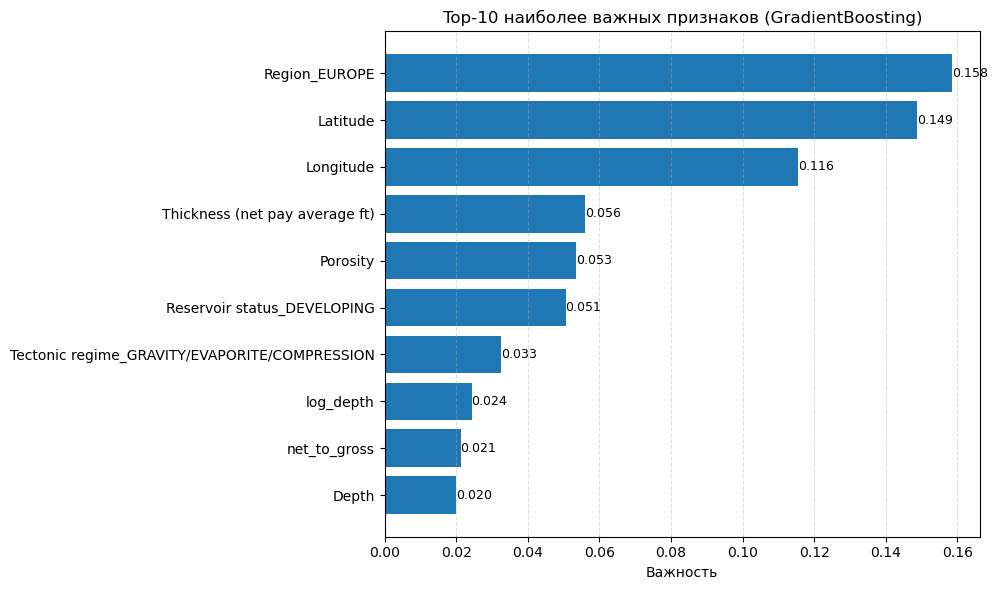

In [34]:
# Извлекаем имена признаков
ohe = best_model.named_steps["preprocess"].named_transformers_["cat"].named_steps["onehot"]
cat_feature_names = ohe.get_feature_names_out(categorical_features)
feature_names = np.concatenate([numeric_features_extended, cat_feature_names])

# Важности признаков
gb_clf = best_model.named_steps["clf"]
feat_imp = (
    pd.DataFrame({"feature": feature_names,
                  "importance": gb_clf.feature_importances_})
    .sort_values(by="importance", ascending=False))
display(feat_imp.head(20))

# График топ-10
top_n = 10
feat_top = feat_imp.head(top_n).iloc[::-1]
plt.figure(figsize=(10, 6))
plt.barh(feat_top["feature"], feat_top["importance"])
plt.title("Top-10 наиболее важных признаков (GradientBoosting)")
plt.xlabel("Важность")
plt.grid(axis="x", linestyle="--", alpha=0.4)

for y, v in enumerate(feat_top["importance"]):
    plt.text(v, y, f"{v:.3f}", va="center", ha="left", fontsize=9)
    
plt.tight_layout()
plt.show()

- **Географические признаки**  
   Ведущие по важности: **Region_EUROPE** (0.16), **Latitude** (0.13), **Longitude** (0.12). Географическое положение месторождения (регион и координаты) являются ключевой фактор при разделении onshore/offshore

- **Физические характеристики**  
   В топ-10 входят **Thickness (net pay average ft)**, **Porosity**, **Permeability**, **Depth**, а также сконструированные признаки **net_to_gross** и **log_depth** (важностями  0.02–0.05). Это также отражает, что физические характеристики заметно влияют на тип месторождения

- **Категориальные признаки**  
   Важный вклад дают **Reservoir status_DEVELOPING**, отдельные категории **Tectonic regime** и **Basin name**. Статус разработки и тектоническая обстановка дополняют информацию о местоположении и физических параметрах.

## 7. Обучение настроенного GradientBoosting на всём train

Используем лучшую модель, обученную на всех тренировочных данных (`X_full`, `y_full`), чтобы получить предсказания по тестовому набору и сформировать итоговый файл

In [38]:
# Готовим X_test 
X_test = test_prep[feature_cols].copy()
X_test["net_to_gross"] = X_test["Thickness (net pay average ft)"] / X_test["Thickness (gross average ft)"]
X_test["log_depth"] = np.log1p(X_test["Depth"])

# Переобучаем лучшую модель 
best_model.fit(X_full, y_full)

# Предсказываем классы (0/1/2)
test_pred = best_model.predict(X_test)

# Формируем отдельный csv-файл с результатми 
submission = pd.DataFrame({
    "index": X_test.index,
    "Onshore/Offshore": test_pred})
display(submission.head())
submission.to_csv("submission.csv", index=False)
print("Файл submission.csv сохранён.")

,index,Onshore/Offshore
0,0,1
1,1,0
2,2,1
3,3,0
4,4,1


Файл submission.csv сохранён.


## Выводы
Выполнен полный цикл решения задачи: EDA, предобработка, feature engineering и сравнение моделей по F1-macro. Лучшей оказалась настроенная GradientBoosting-модель, опирающаяся в основном на географические и физические признаки. На её основе получены предсказания для test и сформирован файл для Kaggle.

Cкриншот строки с результатом из лидерборда Kaggle: https://disk.yandex.ru/i/M2EVZPbx6TYXWw